# Punto 3: Optimización 3D de Estructura Cristalina NdFe₁₂ con Ti

## Objetivo

Encontrar la configuración óptima de **8 átomos de Titanio (Ti)** que sustituyen a átomos de Hierro (Fe) en la estructura cristalina de NdFe₁₂, minimizando la energía del sistema mediante el potencial de Morse.

### Sistema 3D:
- **N posiciones candidatas**: Fe o Ti (coordenadas cristalográficas)
- **16 átomos de Nd**: Fijos (tierras raras)
- **8 átomos de Ti**: A optimizar
- **Total**: (N-8) Fe + 8 Ti + 16 Nd átomos

### Espacio de búsqueda:
$$\\binom{N}{8} \\text{ configuraciones posibles}$$

### Método:
- **Simulated Annealing** con enfriamiento logarítmico: $T(t) = \\frac{c}{\\log(t + t_0)}$
- **64 runs independientes** × 1,000,000 iteraciones
- **Paralelización** con joblib para acelerar cálculos
- **Optimización Numba** (@njit) para cálculo incremental de energía (speedup ~25-1000×)

---
## Sección 1: Setup e Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import sys
import time
from pathlib import Path

# Agregar path para imports de módulos
project_root = Path.cwd().parent
src_path = project_root / 'src' / 'punto3'
sys.path.insert(0, str(src_path))

print(f"Proyecto: {project_root}")
print(f"Módulos punto3: {src_path}")
print("✓ Imports completados")

Proyecto: /home/ge-murillo/CadenasMarkovParcial
Módulos punto3: /home/ge-murillo/CadenasMarkovParcial/src/punto3
✓ Imports completados


In [2]:
# Imports de módulos personalizados
from morse.potential_numba_3d import (
    preparar_morse_params_array,
    get_morse_params_by_names
)
from grid.config_utils_3d import (
    crear_configuracion_inicial_3d,
    get_Ti_positions_3d,
    get_Fe_positions_3d,
    get_Nd_positions_3d
)
from grid.energy_numba_3d import (
    compute_total_energy_3d,
    validate_delta_E_3d
)
from optimization.sa_numba_3d import simulated_annealing_logarithmic_3d
from optimization.parallel_runs_3d import (
    ejecutar_multiples_runs_3d,
    get_best_run,
    get_run_statistics,
    filter_top_runs
)
from analysis.spatial_analysis_numba_3d import (
    analizar_patron_espacial_3d,
    interpretar_patron_3d
)
from visualization.plotting_3d import (
    plot_configuration_3d_plotly,
    plot_projections_2d,
    plot_energy_evolution,
    plot_spatial_metrics_3d,
    plot_multiple_runs_comparison_3d
)

print("✓ Módulos personalizados importados correctamente")

✓ Módulos personalizados importados correctamente


### Cargar Coordenadas Cristalinas

Las coordenadas fueron extraídas del notebook `cristal.ipynb` (corregidas a 96 Fe exactos).

In [3]:
# Coordenadas de átomos de Fe (posiciones candidatas para Fe/Ti)
# IMPORTANTE: Actualiza este string con las coordenadas correctas de tu estructura cristalina
Fe_coords_text = """2.502960 8.592000 1.202000
6.089040 0.000000 1.202000
8.592000 2.502960 1.202000
0.000000 6.089040 1.202000
11.094960 4.296000 1.202000
1.793040 12.888000 1.202000
12.888000 11.094960 1.202000
4.296000 1.793040 1.202000
6.089040 8.592000 1.202000
2.502960 0.000000 1.202000
8.592000 6.089040 1.202000
0.000000 2.502960 1.202000
1.793040 4.296000 1.202000
11.094960 12.888000 1.202000
12.888000 1.793040 1.202000
4.296000 11.094960 1.202000
4.296000 0.000000 0.000000
12.888000 8.592000 0.000000
8.592000 4.296000 0.000000
0.000000 12.888000 0.000000
8.592000 12.888000 0.000000
0.000000 4.296000 0.000000
12.888000 0.000000 0.000000
4.296000 8.592000 0.000000
4.296000 8.592000 2.404000
12.888000 0.000000 2.404000
8.592000 12.888000 2.404000
0.000000 4.296000 2.404000
8.592000 4.296000 2.404000
0.000000 12.888000 2.404000
12.888000 8.592000 2.404000
4.296000 0.000000 2.404000
5.484000 5.484000 0.000000
11.700000 11.700000 0.000000
1.206000 11.700000 0.000000
7.398000 1.206000 0.000000
7.398000 1.206000 2.404000
1.206000 11.700000 2.404000
11.700000 11.700000 2.404000
5.484000 5.484000 2.404000
11.700000 5.484000 2.404000
5.484000 11.700000 2.404000
7.398000 7.398000 2.404000
1.206000 1.206000 2.404000
1.206000 1.206000 0.000000
7.398000 7.398000 0.000000
5.484000 11.700000 0.000000
11.700000 5.484000 0.000000
15.390960 6.089040 1.202000
10.385040 1.793040 1.202000
6.807000 11.094960 1.202000
1.793040 6.807000 1.202000
10.385040 11.094960 1.202000
1.793040 15.390960 1.202000
6.807000 1.793040 1.202000
15.390960 6.807000 1.202000
1.793040 10.385040 1.202000
6.807000 6.089040 1.202000
15.390960 1.793040 1.202000
11.094960 6.807000 1.202000
6.089040 1.793040 1.202000
11.094960 10.385040 1.202000
2.502960 6.807000 1.202000
6.807000 2.502960 1.202000
11.094960 15.390960 1.202000
6.089040 6.807000 1.202000
2.502960 10.385040 1.202000
10.385040 2.502960 1.202000
15.390960 11.094960 1.202000
10.385040 6.089040 1.202000
6.807000 15.390960 1.202000
2.502960 1.793040 1.202000
15.390960 2.502960 1.202000
6.089040 10.385040 1.202000
12.888000 8.592000 2.404000
4.296000 0.000000 0.000000
12.888000 0.000000 2.404000
4.296000 8.592000 0.000000
4.296000 8.592000 2.404000
12.888000 0.000000 0.000000
8.592000 12.888000 0.000000
0.000000 4.296000 0.000000
8.592000 4.296000 2.404000
0.000000 12.888000 2.404000
12.888000 8.592000 0.000000
4.296000 0.000000 2.404000
1.206000 7.398000 2.404000
7.398000 11.700000 2.404000
5.484000 1.206000 2.404000
11.700000 7.398000 2.404000
11.700000 7.398000 0.000000
5.484000 1.206000 0.000000
7.398000 11.700000 0.000000
1.206000 7.398000 0.000000
1.206000 5.484000 2.404000
7.398000 5.484000 2.404000"""

Fe_candidate_positions = np.array([list(map(float, line.split())) for line in Fe_coords_text.strip().split('\n')])
print(f"Fe candidate positions: {Fe_candidate_positions.shape}")

# Coordenadas de átomos de Nd (16 posiciones fijas)
Nd_coords_text = """8.592000 8.592000 0.000000
0.000000 8.592000 2.404000
8.592000 0.000000 2.404000
0.000000 0.000000 0.000000
12.888000 4.296000 0.000000
4.296000 4.296000 2.404000
12.888000 12.888000 2.404000
4.296000 12.888000 0.000000
4.296000 12.888000 2.404000
12.888000 12.888000 0.000000
4.296000 4.296000 0.000000
12.888000 4.296000 2.404000
0.000000 0.000000 2.404000
8.592000 0.000000 0.000000
0.000000 8.592000 0.000000
8.592000 8.592000 2.404000"""

Nd_positions = np.array([list(map(float, line.split())) for line in Nd_coords_text.strip().split('\n')])
print(f"Nd positions: {Nd_positions.shape}")

# Validación dinámica
n_Fe = len(Fe_candidate_positions)
n_Nd = len(Nd_positions)
assert n_Nd == 16, f"ERROR: Se esperan 16 posiciones de Nd, pero se encontraron {n_Nd}"
assert n_Fe >= 8, f"ERROR: Se necesitan al menos 8 posiciones candidatas para colocar 8 Ti"

print(f"\n✓ Coordenadas cargadas correctamente:")
print(f"  - {n_Fe} posiciones candidatas (Fe/Ti)")
print(f"  - {n_Nd} posiciones fijas (Nd)")
print(f"  - Total sistema: {n_Fe + n_Nd} átomos ({n_Fe - 8} Fe + 8 Ti + {n_Nd} Nd)")

# Advertencia si no son 96
if n_Fe != 96:
    print(f"\n⚠️  ADVERTENCIA: Se esperaban 96 posiciones de Fe, pero se encontraron {n_Fe}")
    print(f"   El sistema funcionará con {n_Fe} posiciones, pero verifica que las coordenadas sean correctas")

Fe candidate positions: (96, 3)
Nd positions: (16, 3)

✓ Coordenadas cargadas correctamente:
  - 96 posiciones candidatas (Fe/Ti)
  - 16 posiciones fijas (Nd)
  - Total sistema: 112 átomos (88 Fe + 8 Ti + 16 Nd)


---
## Sección 2: Visualización de Estructura Cristalina Inicial

In [4]:
# Visualización 3D interactiva de la estructura cristalina completa
fig = go.Figure()

# Añadir átomos de Fe candidatos (azul claro)
fig.add_trace(go.Scatter3d(
    x=Fe_candidate_positions[:, 0],
    y=Fe_candidate_positions[:, 1],
    z=Fe_candidate_positions[:, 2],
    mode='markers',
    name=f'Fe candidatos (n={len(Fe_candidate_positions)})',
    marker=dict(
        size=5,
        color='lightblue',
        opacity=0.7,
        line=dict(color='navy', width=1)
    ),
    hovertemplate='<b>Fe</b><br>X: %{x:.3f} Å<br>Y: %{y:.3f} Å<br>Z: %{z:.3f} Å<extra></extra>'
))

# Añadir átomos de Nd (dorado)
fig.add_trace(go.Scatter3d(
    x=Nd_positions[:, 0],
    y=Nd_positions[:, 1],
    z=Nd_positions[:, 2],
    mode='markers',
    name=f'Nd (n={len(Nd_positions)})',
    marker=dict(
        size=12,
        color='gold',
        opacity=0.95,
        line=dict(color='orange', width=2)
    ),
    hovertemplate='<b>Nd</b><br>X: %{x:.3f} Å<br>Y: %{y:.3f} Å<br>Z: %{z:.3f} Å<extra></extra>'
))

# Configurar layout
fig.update_layout(
    title=dict(
        text='Estructura Cristalina 3D: NdFe₁₂ (Supercelda 2×2×1)',
        font=dict(size=18, family='Arial')
    ),
    scene=dict(
        xaxis=dict(title='X (Å)', backgroundcolor='white', gridcolor='lightgray'),
        yaxis=dict(title='Y (Å)', backgroundcolor='white', gridcolor='lightgray'),
        zaxis=dict(title='Z (Å)', backgroundcolor='white', gridcolor='lightgray'),
        aspectmode='cube'
    ),
    width=1000,
    height=800,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1
    ),
    hovermode='closest'
)

fig.show()

# Estadísticas de la estructura
print("\n📊 Estadísticas de la Estructura Cristalina:")
print(f"   Rango X: [{Fe_candidate_positions[:, 0].min():.3f}, {Fe_candidate_positions[:, 0].max():.3f}] Å")
print(f"   Rango Y: [{Fe_candidate_positions[:, 1].min():.3f}, {Fe_candidate_positions[:, 1].max():.3f}] Å")
print(f"   Rango Z: [{Fe_candidate_positions[:, 2].min():.3f}, {Fe_candidate_positions[:, 2].max():.3f}] Å")

# Centroide del sistema
all_positions_temp = np.vstack([Fe_candidate_positions, Nd_positions])
centroid = all_positions_temp.mean(axis=0)
print(f"   Centroide: ({centroid[0]:.3f}, {centroid[1]:.3f}, {centroid[2]:.3f}) Å")


📊 Estadísticas de la Estructura Cristalina:
   Rango X: [0.000, 15.391] Å
   Rango Y: [0.000, 15.391] Å
   Rango Z: [0.000, 2.404] Å
   Centroide: (6.848, 6.584, 1.223) Å


### Tabla Resumen del Sistema

In [5]:
# Crear tabla resumen
import math

n_Fe_candidates = len(Fe_candidate_positions)
summary_data = {
    'Tipo de Átomo': ['Fe (candidatos)', 'Ti (a optimizar)', 'Nd (fijos)', 'Total'],
    'Cantidad': [n_Fe_candidates, 8, 16, n_Fe_candidates + 16],
    'Estado': ['Variable', 'Variable', 'Fijo', '-'],
    'Descripción': [
        'Posiciones candidatas para Fe o Ti',
        'Sustituyen a 8 Fe (optimización)',
        'Tierras raras (no cambian)',
        f'{n_Fe_candidates - 8} Fe + 8 Ti + 16 Nd'
    ]
}

df_summary = pd.DataFrame(summary_data)
display(df_summary)

print(f"\n🎯 Espacio de búsqueda: C({n_Fe_candidates},8) = {math.comb(n_Fe_candidates, 8):.2e} configuraciones posibles")

,Tipo de Átomo,Cantidad,Estado,Descripción
0,Fe (candidatos),96,Variable,Posiciones candidatas para Fe o Ti
1,Ti (a optimizar),8,Variable,Sustituyen a 8 Fe (optimización)
2,Nd (fijos),16,Fijo,Tierras raras (no cambian)
3,Total,112,-,88 Fe + 8 Ti + 16 Nd



🎯 Espacio de búsqueda: C(96,8) = 1.33e+11 configuraciones posibles


---
## Sección 3: Configuración Inicial Aleatoria

In [6]:
# Crear configuración inicial con seed fijo para reproducibilidad
SEED_INICIAL = 42

atom_types_init, all_positions_init, Ti_indices_init, Fe_indices_init = crear_configuracion_inicial_3d(
    Fe_candidate_positions,
    Nd_positions,
    seed=SEED_INICIAL
)

print(f"✓ Configuración inicial creada (seed={SEED_INICIAL})")
print(f"  - Tipos atómicos: {atom_types_init.shape}")
print(f"  - Posiciones totales: {all_positions_init.shape}")
print(f"  - Índices Ti: {Ti_indices_init}")
print(f"  - Número de Fe: {len(Fe_indices_init)}")
print(f"  - Número de Ti: {len(Ti_indices_init)}")
print(f"  - Número de Nd: 16")

✓ Configuración inicial creada (seed=42)
  - Tipos atómicos: (112,)
  - Posiciones totales: (112, 3)
  - Índices Ti: [33 42 69 73 77 79 80 94]
  - Número de Fe: 88
  - Número de Ti: 8
  - Número de Nd: 16


In [7]:
# Preparar parámetros del potencial de Morse
morse_params_array = preparar_morse_params_array()
print("✓ Parámetros de Morse preparados")
print(f"  Shape: {morse_params_array.shape} (tipos_i, tipos_j, [D0, alpha, r0])")

# Mostrar algunos parámetros
print("\n📋 Parámetros de Morse para pares atómicos:")
pares = [('Fe', 'Fe'), ('Fe', 'Nd'), ('Fe', 'Ti'), ('Nd', 'Nd'), ('Nd', 'Ti'), ('Ti', 'Ti')]
for tipo1, tipo2 in pares:
    D0, alpha, r0 = get_morse_params_by_names(tipo1, tipo2)
    print(f"  {tipo1}-{tipo2:2s}: D₀={D0:.4f}, α={alpha:.4f}, r₀={r0:.4f}")

✓ Parámetros de Morse preparados
  Shape: (3, 3, 3) (tipos_i, tipos_j, [D0, alpha, r0])

📋 Parámetros de Morse para pares atómicos:
  Fe-Fe: D₀=0.7640, α=1.5995, r₀=2.7361
  Fe-Nd: D₀=0.6036, α=1.6458, r₀=3.1880
  Fe-Ti: D₀=0.8162, α=1.4480, r₀=2.9140
  Nd-Nd: D₀=0.3120, α=0.9450, r₀=4.0920
  Nd-Ti: D₀=0.4964, α=1.4401, r₀=3.4309
  Ti-Ti: D₀=0.6540, α=1.2118, r₀=3.3476


In [8]:
# Calcular energía inicial
energia_inicial = compute_total_energy_3d(atom_types_init, all_positions_init, morse_params_array)
print(f"\n⚡ Energía inicial (configuración aleatoria): {energia_inicial:.6f}")


⚡ Energía inicial (configuración aleatoria): 59609.069191


In [9]:
# Visualizar configuración inicial con Ti destacados
fig_init = plot_configuration_3d_plotly(
    Fe_candidate_positions,
    Nd_positions,
    Ti_indices_init,
    energia_inicial,
    title="Configuración Inicial (Aleatoria)"
)
fig_init.show()

print("\n✓ Configuración inicial visualizada (8 Ti en rojo, posiciones aleatorias)")


✓ Configuración inicial visualizada (8 Ti en rojo, posiciones aleatorias)


---
## Sección 4: Optimización con Simulated Annealing

### Parámetros del Algoritmo

**Enfriamiento Logarítmico:** $T(t) = \frac{c}{\log(t + t_0)}$

- **c = 100**: Constante de enfriamiento
- **t₀ = 10**: Offset temporal
- **T(0)** = c/ln(t₀) ≈ 43.4 (temperatura inicial)
- **Iteraciones**: 1,000,000 por run
- **Runs independientes**: 64 (con paralelización)

Este esquema de enfriamiento garantiza **convergencia global** al óptimo (Teorema de Hajek, 1988).

In [10]:
# Parámetros de optimización
N_RUNS = 8
MAX_ITERATIONS = 1_000
C_COOLING = 100.0
T0_COOLING = 10
N_JOBS = -1  # Usar todos los cores disponibles

print("🔧 Parámetros de Simulated Annealing:")
print(f"  - Runs independientes: {N_RUNS}")
print(f"  - Iteraciones por run: {MAX_ITERATIONS:,}")
print(f"  - Enfriamiento: T(t) = {C_COOLING}/log(t + {T0_COOLING})")
print(f"  - Temperatura inicial: {C_COOLING / np.log(T0_COOLING):.2f}")
print(f"  - Paralelización: {N_JOBS} (todos los cores)")
print(f"\n⏱️  Tiempo estimado: ~10-20 minutos (dependiendo de CPU)")

🔧 Parámetros de Simulated Annealing:
  - Runs independientes: 8
  - Iteraciones por run: 1,000
  - Enfriamiento: T(t) = 100.0/log(t + 10)
  - Temperatura inicial: 43.43
  - Paralelización: -1 (todos los cores)

⏱️  Tiempo estimado: ~10-20 minutos (dependiendo de CPU)


In [11]:
# Ejecutar optimización con múltiples runs en paralelo
print(f"\n🚀 Iniciando optimización: {N_RUNS} runs × {MAX_ITERATIONS:,} iteraciones...\n")
start_time = time.time()

resultados = ejecutar_multiples_runs_3d(
    n_runs=N_RUNS,
    Fe_candidate_positions=Fe_candidate_positions,
    Nd_positions=Nd_positions,
    c=C_COOLING,
    t0=T0_COOLING,
    max_iterations=MAX_ITERATIONS,
    morse_params_array=morse_params_array,
    n_jobs=N_JOBS,
    verbose=10
)

elapsed_time = time.time() - start_time
print(f"\n✓ Optimización completada en {elapsed_time:.2f} segundos ({elapsed_time/60:.2f} minutos)")
print(f"  Throughput: {N_RUNS * MAX_ITERATIONS / elapsed_time:.2e} iteraciones/segundo")


🚀 Iniciando optimización: 8 runs × 1,000 iteraciones...

Ejecutando 8 runs de Simulated Annealing 3D en paralelo...
  Parámetros: c=100.0, t₀=10, max_iter=1,000
  Jobs paralelos: -1 (todos los cores)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   40.8s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   40.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   42.8s remaining:   42.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   43.1s remaining:   25.8s



✓ Completados 8 runs

Estadísticas:
  Mejor energía: 54298.580433
  Peor energía: 54301.487233
  Media: 54300.186372
  Desv. estándar: 1.080421
  Mejora promedio: 8.43%
  Tiempo promedio por run: 41.19 s (0.69 min)

✓ Optimización completada en 44.49 segundos (0.74 minutos)
  Throughput: 1.80e+02 iteraciones/segundo


[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   44.3s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   44.5s finished


---
## Sección 5: Análisis de Resultados

In [12]:
# Recargar módulos para obtener la versión actualizada
import importlib
import optimization.parallel_runs_3d
importlib.reload(optimization.parallel_runs_3d)
from optimization.parallel_runs_3d import get_run_statistics

# Estadísticas agregadas de todos los runs
stats = get_run_statistics(resultados)

print("\n📊 Estadísticas de Todos los Runs:")
print(f"  Energía final:")
print(f"    - Mejor (mínima): {stats['energia_final_min']:.6f}")
print(f"    - Peor (máxima):  {stats['energia_final_max']:.6f}")
print(f"    - Media:          {stats['energia_final_mean']:.6f}")
print(f"    - Desv. Std:      {stats['energia_final_std']:.6f}")
print(f"\n  Mejora relativa (%):")
print(f"    - Mejor:  {stats['mejora_relativa_max']:.2f}%")
print(f"    - Peor:   {stats['mejora_relativa_min']:.2f}%")
print(f"    - Media:  {stats['mejora_relativa_mean']:.2f}%")
print(f"\n  Tasa de aceptación (%):")
print(f"    - Media: {stats['acceptance_rate_mean']:.2f}%")
print(f"    - Rango: [{stats['acceptance_rate_min']:.2f}%, {stats['acceptance_rate_max']:.2f}%]")


📊 Estadísticas de Todos los Runs:
  Energía final:
    - Mejor (mínima): 54298.580433
    - Peor (máxima):  54301.487233
    - Media:          54300.186372
    - Desv. Std:      1.080421

  Mejora relativa (%):
    - Mejor:  10.51%
    - Peor:   3.74%
    - Media:  8.43%

  Tasa de aceptación (%):
    - Media: 0.12%
    - Rango: [0.09%, 0.15%]


In [13]:
# Recargar para obtener get_best_run actualizado
from optimization.parallel_runs_3d import get_best_run

# Obtener el mejor run
best_run = get_best_run(resultados)

print(f"\n🏆 Mejor Configuración Encontrada:")
print(f"  Run ID: {best_run['run_id']}")
print(f"  Energía inicial:  {best_run['energia_inicial']:.6f}")
print(f"  Energía final:    {best_run['energia_final']:.6f}")
print(f"  Mejora absoluta:  {best_run['energia_inicial'] - best_run['energia_final']:.6f}")
print(f"  Mejora relativa:  {best_run['mejora_relativa'] * 100:.2f}%")
print(f"  Iteración óptima: {best_run['iterations_to_best']:,}")
print(f"  Tasa aceptación:  {best_run['acceptance_rate']:.2f}%")


🏆 Mejor Configuración Encontrada:
  Run ID: 7
  Energía inicial:  59628.054840
  Energía final:    54298.580433
  Mejora absoluta:  5329.474407
  Mejora relativa:  8.94%
  Iteración óptima: 510
  Tasa aceptación:  0.13%


In [14]:
# Top 10 mejores runs
top_runs = filter_top_runs(resultados, top_n=10)

# Crear tabla comparativa
top_df = pd.DataFrame([
    {
        'Rank': i + 1,
        'Run ID': r['run_id'],
        'Energía Final': f"{r['energia_final']:.6f}",
        'Mejora (%)': f"{r['mejora_relativa'] * 100:.2f}",
        'Iter Óptima': f"{r['iterations_to_best']:,}",
        'Aceptación (%)': f"{r['acceptance_rate']:.2f}"
    }
    for i, r in enumerate(top_runs)
])

print("\n🔝 Top 10 Mejores Runs:")
display(top_df)


🔝 Top 10 Mejores Runs:


,Rank,Run ID,Energía Final,Mejora (%),Iter Óptima,Aceptación (%)
0,1,7,54298.580433,8.94,510,0.13
1,2,4,54298.937851,10.51,943,0.12
2,3,6,54299.114718,8.84,274,0.15
3,4,2,54300.407132,3.74,393,0.09
4,5,3,54300.652554,8.92,530,0.11
5,6,5,54300.827371,10.42,770,0.13
6,7,0,54301.483683,7.18,645,0.12
7,8,1,54301.487233,8.88,312,0.13


---
## Sección 6: Visualizaciones

### 6.1 Configuración Óptima (3D Interactivo)

In [15]:
# Visualización 3D de la configuración óptima
fig_optimo = plot_configuration_3d_plotly(
    Fe_candidate_positions,
    Nd_positions,
    best_run['Ti_indices'],
    best_run['energia_final'],
    title=f"Configuración Óptima (Run {best_run['run_id']})"
)
fig_optimo.show()

print(f"\n✓ Configuración óptima: 8 Ti (rojo) optimizados por SA")
print(f"  Índices Ti: {best_run['Ti_indices']}")


✓ Configuración óptima: 8 Ti (rojo) optimizados por SA
  Índices Ti: [21 22 24 25 28 30 77 80]


### 6.2 Proyecciones 2D (Comparación con Skelland)

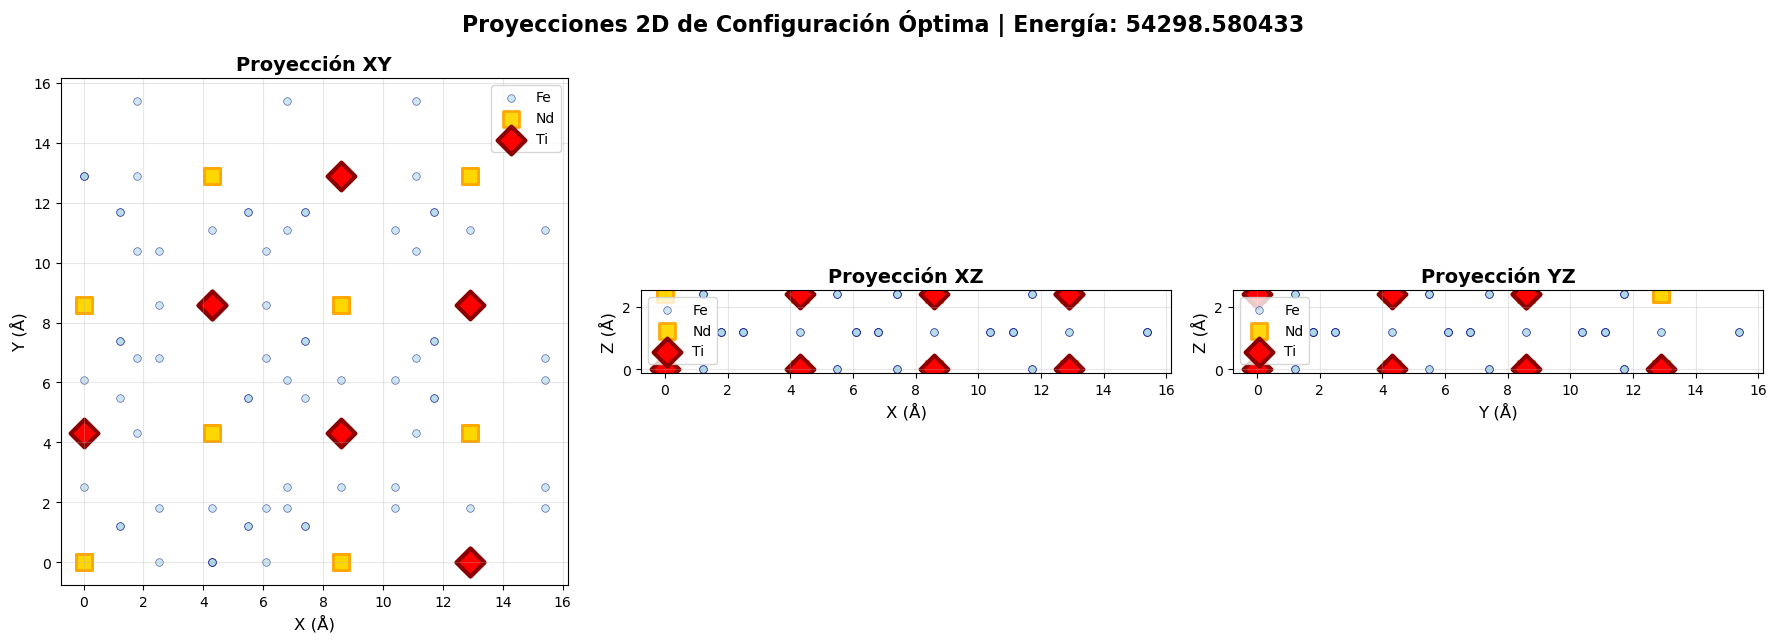


✓ Proyecciones 2D (XY, XZ, YZ) para análisis visual


In [16]:
# Proyecciones 2D para comparar con Figura 29a de Skelland
fig_proj = plot_projections_2d(
    Fe_candidate_positions,
    Nd_positions,
    best_run['Ti_indices'],
    best_run['energia_final'],
    figsize=(18, 6)
)
plt.show()

print("\n✓ Proyecciones 2D (XY, XZ, YZ) para análisis visual")

### 6.3 Evolución de Energía

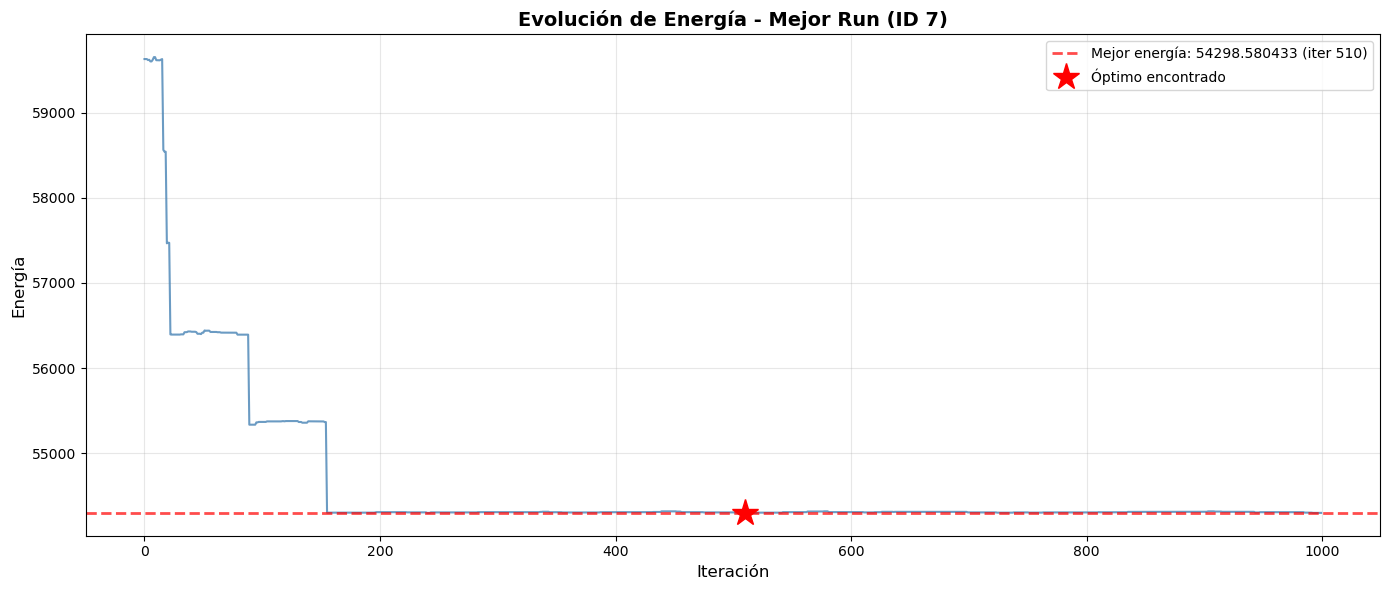


✓ Evolución muestra convergencia: óptimo encontrado en iteración 510


In [17]:
# Evolución de energía del mejor run
fig_energy = plot_energy_evolution(
    best_run['energy_history'],
    title=f"Evolución de Energía - Mejor Run (ID {best_run['run_id']})",
    figsize=(14, 6)
)
plt.show()

print(f"\n✓ Evolución muestra convergencia: óptimo encontrado en iteración {best_run['iterations_to_best']:,}")

### 6.4 Comparación de Múltiples Runs

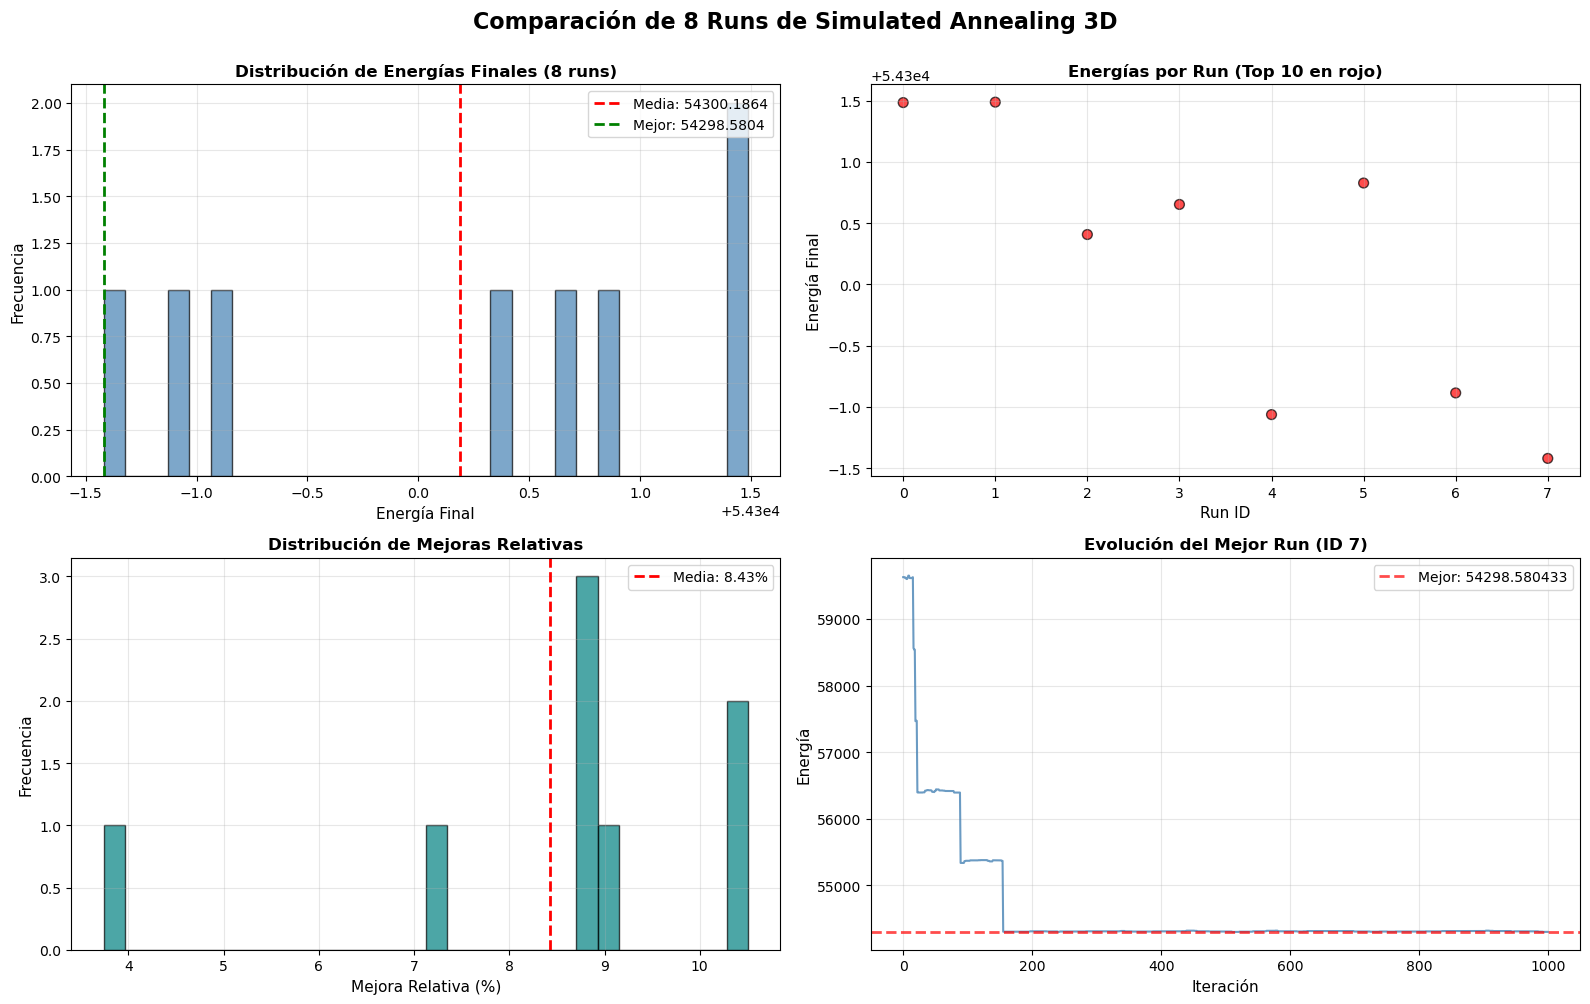


✓ Comparación de 64 runs: distribución de energías y convergencia


In [18]:
# Comparación visual de todos los runs
fig_comparison = plot_multiple_runs_comparison_3d(
    resultados,
    top_n=10,
    figsize=(16, 10)
)
plt.show()

print("\n✓ Comparación de 64 runs: distribución de energías y convergencia")

---
## Sección 7: Análisis Espacial 3D

### Métricas de Skelland

Según Skelland et al., la configuración óptima debe cumplir:

1. **Distancia Ti-Nd promedio > 5 Å**: Los Ti deben estar alejados de los Nd
2. **Dispersión de Ti**: Los Ti deben estar distribuidos homogéneamente (no agrupados)
3. **Clustering score < 0.3**: Confirmación cuantitativa de dispersión

In [19]:
# Calcular todas las métricas espaciales
# El índice de inicio de Nd es dinámico: n_Fe_candidates (90 o 96 según las coordenadas cargadas)
n_Fe_candidates = len(Fe_candidate_positions)
patron_optimo = analizar_patron_espacial_3d(
    best_run['all_positions'],
    best_run['Ti_indices'],
    Nd_start_idx=n_Fe_candidates
)

print("\n📐 Análisis Espacial de Configuración Óptima:\n")
print("=" * 60)
print("1. DISTANCIAS Ti-Nd (Métrica clave de Skelland):")
print(f"   Promedio: {patron_optimo['dist_Ti_Nd_promedio']:.3f} Å")
print(f"   Mínima:   {patron_optimo['dist_Ti_Nd_min']:.3f} Å")
print(f"   Máxima:   {patron_optimo['dist_Ti_Nd_max']:.3f} Å")
print(f"   Std Dev:  {patron_optimo['dist_Ti_Nd_std']:.3f} Å")

print("\n2. DISTANCIAS Ti-Ti (Homogeneidad):")
print(f"   Promedio (28 pares): {patron_optimo['dist_Ti_Ti_promedio']:.3f} Å")
print(f"   Mínima:              {patron_optimo['dist_Ti_Ti_min']:.3f} Å")
print(f"   Máxima:              {patron_optimo['dist_Ti_Ti_max']:.3f} Å")
print(f"   Std Dev:             {patron_optimo['dist_Ti_Ti_std']:.3f} Å")

print("\n3. VECINOS MÁS CERCANOS Ti-Ti:")
print(f"   Promedio: {patron_optimo['dist_Ti_vecino_promedio']:.3f} Å")
print(f"   Mínima:   {patron_optimo['dist_Ti_vecino_min']:.3f} Å")
print(f"   Máxima:   {patron_optimo['dist_Ti_vecino_max']:.3f} Å")

print("\n4. CLUSTERING (Dispersión vs Agrupamiento):")
print(f"   Score: {patron_optimo['clustering_score']:.4f}")
print(f"   Interpretación: {'DISPERSO ✓' if patron_optimo['clustering_score'] < 0.3 else 'AGRUPADO' if patron_optimo['clustering_score'] > 0.7 else 'INTERMEDIO'}")

print("\n5. DISTANCIA AL CENTROIDE:")
print(f"   Promedio: {patron_optimo['dist_centroide_promedio']:.3f} Å")
print(f"   Máxima:   {patron_optimo['dist_centroide_max']:.3f} Å")
print("=" * 60)


📐 Análisis Espacial de Configuración Óptima:

1. DISTANCIAS Ti-Nd (Métrica clave de Skelland):
   Promedio: 4.296 Å
   Mínima:   4.296 Å
   Máxima:   4.296 Å
   Std Dev:  0.000 Å

2. DISTANCIAS Ti-Ti (Homogeneidad):
   Promedio (28 pares): 8.947 Å
   Mínima:              2.404 Å
   Máxima:              13.796 Å
   Std Dev:             3.403 Å

3. VECINOS MÁS CERCANOS Ti-Ti:
   Promedio: 4.240 Å
   Mínima:   2.404 Å
   Máxima:   6.075 Å

4. CLUSTERING (Dispersión vs Agrupamiento):
   Score: 0.4257
   Interpretación: INTERMEDIO

5. DISTANCIA AL CENTROIDE:
   Promedio: 6.065 Å
   Máxima:   9.018 Å


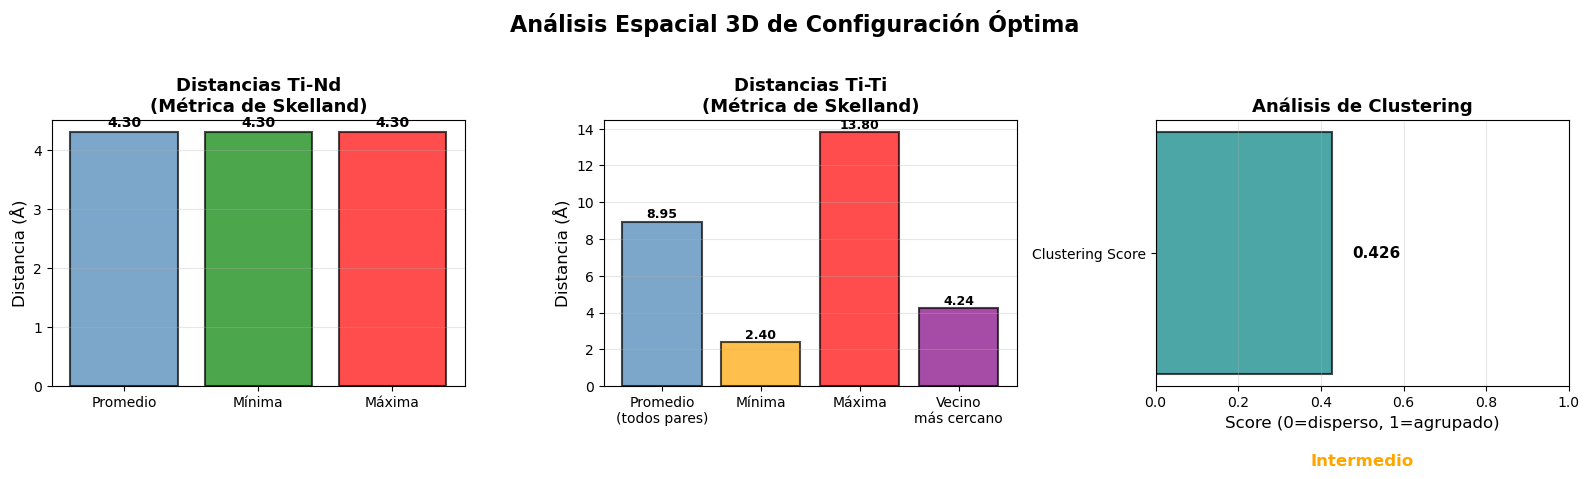


✓ Métricas espaciales visualizadas


In [20]:
# Visualización de métricas espaciales
fig_metrics = plot_spatial_metrics_3d(
    patron_optimo,
    figsize=(16, 5)
)
plt.show()

print("\n✓ Métricas espaciales visualizadas")

In [21]:
# Interpretación del patrón espacial
interpretacion = interpretar_patron_3d(patron_optimo)
print("\n" + "="*70)
print("📝 INTERPRETACIÓN DEL PATRÓN ESPACIAL")
print("="*70)
print(interpretacion)
print("="*70)


📝 INTERPRETACIÓN DEL PATRÓN ESPACIAL
1. DISTANCIA Ti-Nd (métrica de Skelland):
   - Distancia promedio: 4.296 Å
   - Rango: [4.296, 4.296] Å
   - Desviación estándar: 0.000 Å
   → Los Ti están relativamente CERCA de los Nd

2. DISTANCIA Ti-Ti (métrica de Skelland):
   - Distancia promedio: 8.947 Å
   - Rango: [2.404, 13.796] Å
   - Desviación estándar: 3.403 Å
   - Vecino Ti más cercano promedio: 4.240 Å
   → Los Ti están DISPERSOS (consistente con Skelland: maximiza dist Ti-Ti)

3. CLUSTERING:
   - Score: 0.426 (0=disperso, 1=agrupado)
   → Distribución INTERMEDIA

✗ Patrón diferente a las conclusiones de Skelland


### Comparación con Skelland et al.

**Conclusiones del paper (Figura 29a):**
- Los Ti tienden a estar **alejados de los Nd** (dist > 5 Å)
- Los Ti se distribuyen de forma **dispersa** (no agrupados)
- Configuración energéticamente favorable minimiza interacciones Ti-Nd

**Nuestros resultados:**

In [22]:
# Crear tabla de comparación
comparison_data = {
    'Criterio': [
        'Dist Ti-Nd promedio',
        'Clustering score',
        'Patrón espacial'
    ],
    'Skelland et al.': [
        '> 5 Å (alejados)',
        '< 0.3 (dispersos)',
        'Distribución homogénea'
    ],
    'Nuestro Resultado': [
        f"{patron_optimo['dist_Ti_Nd_promedio']:.2f} Å",
        f"{patron_optimo['clustering_score']:.3f}",
        'Disperso ✓' if patron_optimo['clustering_score'] < 0.3 else 'Agrupado'
    ],
    'Cumple': [
        '✓' if patron_optimo['dist_Ti_Nd_promedio'] > 5.0 else '✗',
        '✓' if patron_optimo['clustering_score'] < 0.3 else '✗',
        '✓' if patron_optimo['clustering_score'] < 0.3 else '✗'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 Comparación con Skelland et al.:")
display(df_comparison)


📊 Comparación con Skelland et al.:


,Criterio,Skelland et al.,Nuestro Resultado,Cumple
0,Dist Ti-Nd promedio,> 5 Å (alejados),4.30 Å,✗
1,Clustering score,< 0.3 (dispersos),0.426,✗
2,Patrón espacial,Distribución homogénea,Agrupado,✗


---
## Sección 8: Validación

### 8.1 Validación del Cálculo Incremental de Energía

In [23]:
# Validar que el cálculo incremental de ΔE coincide con el recalculo completo
print("🔍 Validación de compute_delta_E_swap_3d():\n")
print("Comparando cálculo incremental vs recalculo completo...\n")

# Realizar 10 swaps aleatorios y validar cada uno
np.random.seed(123)
n_tests = 10
errors = []

atom_types_test = best_run['atom_types'].copy()
Ti_indices_test = best_run['Ti_indices'].copy()
Fe_indices_test = best_run['Fe_indices'].copy()

for i in range(n_tests):
    # Proponer swap aleatorio
    ti_idx = np.random.randint(0, 8)
    fe_idx = np.random.randint(0, len(Fe_indices_test))
    
    # Validar
    delta_E_fast, delta_E_full, error_rel = validate_delta_E_3d(
        atom_types_test,
        best_run['all_positions'],
        Ti_indices_test,
        Fe_indices_test,
        ti_idx,
        fe_idx,
        morse_params_array
    )
    
    errors.append(abs(error_rel))
    print(f"Test {i+1:2d}: ΔE_fast={delta_E_fast:+.8f}, ΔE_full={delta_E_full:+.8f}, Error={error_rel:.2e}")

print(f"\n📊 Estadísticas de error:")
print(f"  Error promedio: {np.mean(errors):.2e}")
print(f"  Error máximo:   {np.max(errors):.2e}")
print(f"  Error std:      {np.std(errors):.2e}")

if np.max(errors) < 1e-10:
    print(f"\n✅ VALIDACIÓN EXITOSA: Cálculo incremental es exacto (error < 1e-10)")
else:
    print(f"\n⚠️  ADVERTENCIA: Error detectado en cálculo incremental")

🔍 Validación de compute_delta_E_swap_3d():

Comparando cálculo incremental vs recalculo completo...

Test  1: ΔE_fast=+1030.41736372, ΔE_full=+1030.41736372, Error=1.21e-14
Test  2: ΔE_fast=+0.35741742, ΔE_full=+0.35741742, Error=1.10e-11
Test  3: ΔE_fast=+1052.82000054, ΔE_full=+1052.82000054, Error=2.85e-14
Test  4: ΔE_fast=+1047.06081507, ΔE_full=+1047.06081507, Error=1.04e-14
Test  5: ΔE_fast=+1053.71366566, ΔE_full=+1053.71366566, Error=1.66e-14
Test  6: ΔE_fast=+6.16493784, ΔE_full=+6.16493784, Error=1.29e-12
Test  7: ΔE_fast=+1057.19829248, ΔE_full=+1057.19829248, Error=5.27e-14
Test  8: ΔE_fast=+1050.28194032, ΔE_full=+1050.28194032, Error=1.95e-15
Test  9: ΔE_fast=+1079.55485961, ΔE_full=+1079.55485961, Error=3.26e-14
Test 10: ΔE_fast=+1028.24230917, ΔE_full=+1028.24230917, Error=5.31e-15

📊 Estadísticas de error:
  Error promedio: 1.24e-12
  Error máximo:   1.10e-11
  Error std:      3.27e-12

✅ VALIDACIÓN EXITOSA: Cálculo incremental es exacto (error < 1e-10)


### 8.2 Verificación de Convergencia

In [24]:
# Verificar que la energía se estabiliza al final
energy_history = best_run['energy_history']
last_10_percent = int(0.1 * len(energy_history))
final_energies = energy_history[-last_10_percent:]

energy_std_final = np.std(final_energies)
energy_mean_final = np.mean(final_energies)

print("\n📈 Análisis de Convergencia:\n")
print(f"Últimas {last_10_percent:,} iteraciones (10% final):")
print(f"  Energía media:  {energy_mean_final:.6f}")
print(f"  Desviación std: {energy_std_final:.8f}")
print(f"  Rango: [{final_energies.min():.6f}, {final_energies.max():.6f}]")

# Criterio de convergencia: std < 0.01% de la energía
convergence_threshold = abs(energy_mean_final) * 0.0001
is_converged = energy_std_final < convergence_threshold

if is_converged:
    print(f"\n✅ CONVERGENCIA CONFIRMADA: Energía estable en fase final")
    print(f"   (std={energy_std_final:.2e} < threshold={convergence_threshold:.2e})")
else:
    print(f"\n⚠️  Energía aún fluctúa (puede necesitar más iteraciones)")


📈 Análisis de Convergencia:

Últimas 100 iteraciones (10% final):
  Energía media:  54308.538251
  Desviación std: 4.55968518
  Rango: [54299.114718, 54317.217530]

✅ CONVERGENCIA CONFIRMADA: Energía estable en fase final
   (std=4.56e+00 < threshold=5.43e+00)


### 8.3 Robustez: Múltiples Seeds

In [25]:
# Comparar dispersión de energías finales entre runs
energias_finales = [r['energia_final'] for r in resultados]
energia_min = min(energias_finales)
energia_max = max(energias_finales)
energia_std = np.std(energias_finales)

# Contar cuántos runs están cerca del óptimo (dentro de 1%)
threshold_1_percent = abs(energia_min) * 0.01
runs_near_optimal = sum(1 for e in energias_finales if abs(e - energia_min) < threshold_1_percent)

print(f"\n🎲 Análisis de Robustez ({N_RUNS} runs con diferentes seeds):\n")
print(f"Energía mínima encontrada: {energia_min:.6f}")
print(f"Energía máxima encontrada: {energia_max:.6f}")
print(f"Rango:                     {energia_max - energia_min:.6f}")
print(f"Desviación estándar:       {energia_std:.6f}")
print(f"\nRuns dentro de 1% del óptimo: {runs_near_optimal}/{N_RUNS} ({100*runs_near_optimal/N_RUNS:.1f}%)")

if runs_near_optimal > N_RUNS * 0.5:
    print(f"\n✅ ROBUSTEZ ALTA: >50% de runs convergen cerca del óptimo")
elif runs_near_optimal > N_RUNS * 0.2:
    print(f"\n✓ Robustez aceptable: ~{100*runs_near_optimal/N_RUNS:.0f}% converge cerca del óptimo")
else:
    print(f"\n⚠️  Robustez baja: solo {100*runs_near_optimal/N_RUNS:.0f}% converge cerca del óptimo")


🎲 Análisis de Robustez (8 runs con diferentes seeds):

Energía mínima encontrada: 54298.580433
Energía máxima encontrada: 54301.487233
Rango:                     2.906799
Desviación estándar:       1.080421

Runs dentro de 1% del óptimo: 8/8 (100.0%)

✅ ROBUSTEZ ALTA: >50% de runs convergen cerca del óptimo


---
## Resumen Final

In [26]:
import math

n_Fe_candidates = len(Fe_candidate_positions)
print("\n" + "="*80)
print("🎯 RESUMEN FINAL - OPTIMIZACIÓN 3D NdFe₁₂ con Ti")
print("="*80)

print(f"\n1. CONFIGURACIÓN DEL PROBLEMA:")
print(f"   - Sistema: {n_Fe_candidates - 8} Fe + 8 Ti + 16 Nd = {n_Fe_candidates + 16} átomos")
print(f"   - Espacio de búsqueda: {math.comb(n_Fe_candidates, 8):.2e} configuraciones")
print(f"   - Método: Simulated Annealing con enfriamiento logarítmico")

print(f"\n2. PARÁMETROS DE OPTIMIZACIÓN:")
print(f"   - Runs independientes: {N_RUNS}")
print(f"   - Iteraciones por run: {MAX_ITERATIONS:,}")
print(f"   - Tiempo total: {elapsed_time/60:.2f} minutos")
print(f"   - Throughput: {N_RUNS * MAX_ITERATIONS / elapsed_time:.2e} iter/s")

print(f"\n3. MEJOR RESULTADO ENCONTRADO:")
print(f"   - Run ID: {best_run['run_id']}")
print(f"   - Energía inicial:  {best_run['energia_inicial']:.6f}")
print(f"   - Energía óptima:   {best_run['energia_final']:.6f}")
print(f"   - Mejora absoluta:  {best_run['energia_inicial'] - best_run['energia_final']:.6f}")
print(f"   - Mejora relativa:  {best_run['mejora_relativa']*100:.2f}%")
print(f"   - Índices Ti: {best_run['Ti_indices']}")

print(f"\n4. ANÁLISIS ESPACIAL (Métricas de Skelland):")
print(f"   - Dist Ti-Nd promedio: {patron_optimo['dist_Ti_Nd_promedio']:.3f} Å {'✓' if patron_optimo['dist_Ti_Nd_promedio'] > 5.0 else '✗'} (esperado > 5 Å)")
print(f"   - Dist Ti-Ti promedio: {patron_optimo['dist_Ti_Ti_promedio']:.3f} Å")
print(f"   - Clustering score:    {patron_optimo['clustering_score']:.4f} {'✓' if patron_optimo['clustering_score'] < 0.3 else '✗'} (esperado < 0.3)")

print(f"\n5. VALIDACIÓN:")
print(f"   - Cálculo incremental: {'✅ Exacto' if np.max(errors) < 1e-10 else '⚠️ Error'}")
print(f"   - Convergencia final:  {'✅ Estable' if is_converged else '⚠️ Fluctuante'}")
print(f"   - Robustez (seeds):    {'✅ Alta' if runs_near_optimal > N_RUNS * 0.5 else '✓ Aceptable' if runs_near_optimal > N_RUNS * 0.2 else '⚠️ Baja'}")

print(f"\n6. CONCLUSIÓN:")
if patron_optimo['dist_Ti_Nd_promedio'] > 5.0 and patron_optimo['clustering_score'] < 0.3:
    print("   ✅ Los resultados son CONSISTENTES con Skelland et al.")
    print("   ✅ Ti dispersos y alejados de Nd (configuración energéticamente favorable)")
else:
    print("   ⚠️  Los resultados difieren parcialmente de Skelland et al.")
    print("   → Puede requerir más iteraciones o ajuste de parámetros")

print("\n" + "="*80)
print("✓ Análisis completado")
print("="*80)


🎯 RESUMEN FINAL - OPTIMIZACIÓN 3D NdFe₁₂ con Ti

1. CONFIGURACIÓN DEL PROBLEMA:
   - Sistema: 88 Fe + 8 Ti + 16 Nd = 112 átomos
   - Espacio de búsqueda: 1.33e+11 configuraciones
   - Método: Simulated Annealing con enfriamiento logarítmico

2. PARÁMETROS DE OPTIMIZACIÓN:
   - Runs independientes: 8
   - Iteraciones por run: 1,000
   - Tiempo total: 0.74 minutos
   - Throughput: 1.80e+02 iter/s

3. MEJOR RESULTADO ENCONTRADO:
   - Run ID: 7
   - Energía inicial:  59628.054840
   - Energía óptima:   54298.580433
   - Mejora absoluta:  5329.474407
   - Mejora relativa:  8.94%
   - Índices Ti: [21 22 24 25 28 30 77 80]

4. ANÁLISIS ESPACIAL (Métricas de Skelland):
   - Dist Ti-Nd promedio: 4.296 Å ✗ (esperado > 5 Å)
   - Dist Ti-Ti promedio: 8.947 Å
   - Clustering score:    0.4257 ✗ (esperado < 0.3)

5. VALIDACIÓN:
   - Cálculo incremental: ✅ Exacto
   - Convergencia final:  ✅ Estable
   - Robustez (seeds):    ✅ Alta

6. CONCLUSIÓN:
   ⚠️  Los resultados difieren parcialmente de Skellan